# Medium Article Text Analysis

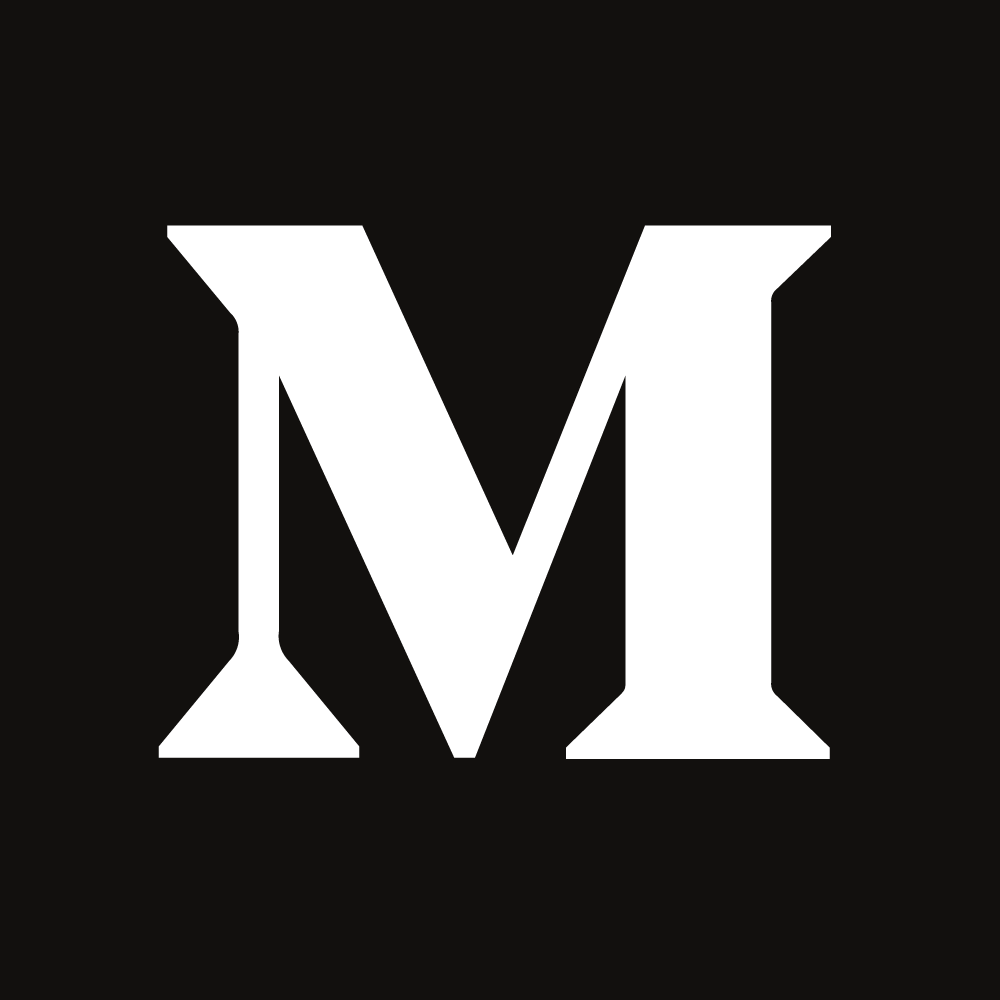

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import nltk, re, multiprocessing
nltk.download("stopwords")
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
import spacy
from zipfile import ZipFile
import os
from wordcloud import WordCloud
from gensim.models.phrases import Phrases, Phraser
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [ ]:
data = pd.read_csv("/kaggle/input/medium-articles/articles.csv")
data.head()

Here our aim will be mainly on text analysis.

In [ ]:
data.shape

In [ ]:
data["author"].nunique()

So in our dataset, there are 182 total authors, who have written articles. Now before jumping straight to text processing, we will form a word cloud to see what are there in our text.

In [ ]:
cloud=WordCloud(colormap="Reds",width=600,height=400).generate(str(data["text"]))
fig=plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Word Cloud on uncleaned text", size = 20)

In [ ]:
pd.set_option('display.max_colwidth', None)
data["text"].head()

In [ ]:
def cleaned_data_3(text):
    cleaned_txt = re.sub("AI","Artificial Intelligence", text)
    return cleaned_txt
data["text"] = data["text"].apply(cleaned_data_3)

Also let's see for title column. But here we will work mainly with text column.

In [ ]:
pd.set_option('display.max_colwidth', None)
data["title"].head()

# Basic Text Pre-processing

In [ ]:
def cleaned_text(text_data):
    clean = text_data.lower()
    clean = re.sub("\n"," ",clean)
    clean = re.sub("http\S+"," ",clean)
    clean = re.sub("www\S+"," ",clean)
    #clean = re.sub(r"[,-.:;]"," ", clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
data["cleaned_data"] = data["text"].apply(cleaned_text)

In [ ]:
data["cleaned_data"].head()

# POS Tagging


Now let's do POS tagging using Spacy.

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(str(data["cleaned_data"]))
for token in doc: 
  print(token, token.pos_)
  #print(token, token.lemma_)

In [ ]:
list = [token.pos_ for token in doc]
list = pd.Series(list)
plt.style.use("dark_background")
list.value_counts().plot(figsize = (12,6), kind = "bar", color = "r")
plt.title("Frequency of POS tagger", size = 22)
plt.xlabel("POS tagger", size = 18)

So from the above plot, we can see that most of the POS taggers are nouns. Now let's see word distribution 

In [ ]:
data['Number_of_words'] = data['cleaned_data'].apply(lambda x:len(str(x).split()))

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="springgreen", bins = 100)
plt.title("Frequency distribution of number of words from each text", size = 20)
plt.xlabel("Number of words", size = 18)

Now let's see how many documents belong to word size of more than 5000.

In [ ]:
len(data[data["Number_of_words"]>5000])

Now let's a create wordcloud on the cleaned text data.

In [ ]:
cloud=WordCloud(colormap="spring",width=600,height=400).generate(str(data["cleaned_data"]))
fig=plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')
plt.title("Word Cloud on cleaned text", size = 22)

# Bi-Gram 

Before creating bigram, we should remove stop words, so that bigram formation happens only on real ones.

In [ ]:
stop=stopwords.words('english')
stop.extend(["make","get","also","use","using","used","even","though","could","would","us","much","uses","makes","part"])
data["stopwords_rem"]=data["cleaned_data"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
data["stopwords_rem"].head()

A little more text cleaning, and I am not directly using lemmatization here because of a reason, as here in our documents, words like "Machine Learning", "Deep Learning", etc exists, so I can't use lemmatization here.

In [ ]:
def cleaned_text_2(text):
    #cleaned = text_data.lower()
    cleaned = re.sub("networks","network",text)
    cleaned = re.sub("weeks","week",cleaned)
    cleaned = re.sub("boxes","box",cleaned)
    cleaned = re.sub("algorithms","algorithm",cleaned)
    cleaned = re.sub("functions","function",cleaned)
    cleaned = re.sub("nets","network",cleaned)
    cleaned = re.sub("proposals","proposal",cleaned)
    cleaned = re.sub("imitative ai","imitative artificial intelligence",cleaned)
    cleaned = re.sub("deep rl","deep reinforcement learning",cleaned)
    cleaned = re.sub("word vec","word2vec",cleaned)#crartificial
    cleaned = re.sub("crartificial intelligenceg","artificial intelligence",cleaned)
    cleaned = re.sub("nlp","natural language processing",cleaned)
    cleaned = re.sub("openartificial","open artificial",cleaned)
    cleaned = re.sub("intelligences","intelligence",cleaned)
    return cleaned
data["stopwords_rem"] = data["stopwords_rem"].apply(cleaned_text_2)

Now let's remove single characters from our text data.

In [ ]:
data["stopwords_rem"] = data["stopwords_rem"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>1]))

Also let's see the top 30 most frequent words in our text.

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(data["stopwords_rem"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)

Now let's try to see how word counts have changed for documents after removing stopwords

In [ ]:
data['Number_of_words_after_stpwrd'] = data['stopwords_rem'].apply(lambda x:len(str(x).split()))

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words_after_stpwrd'],kde = False,color="yellow", bins = 100)
plt.title("Histogram showing number of words from each doc after stop removal", size = 18)
plt.xlabel("Number of words", size = 18)

Now let's create a bigram model using Gensim library. We need to convert the input in token form, as Gensim's Phrases takes it in that form only. Then we will try different threshold value before finally settling to one value, so that the important we don't remove important bigrams from our document, and also we need to take care that insignificant bigrams are not created in our document, so we need to take care and maintain a balance. 

In [ ]:
tokens = data["stopwords_rem"].apply(lambda x: nltk.word_tokenize(x))

Bigrams are created based on scores, so only those bigrams will be created which will have score more than the threshold that we set for the model.

In [ ]:
#phrases = Phrases(tokens, min_count = 20, threshold = 50, delimiter=b'_')
#phrases = Phrases(tokens, min_count = 25, threshold = 40, delimiter=b'_')
phrases = Phrases(tokens, min_count = 27, threshold = 41.5, delimiter=b'_')
bigram = Phraser(phrases)

In [ ]:
bigram.phrasegrams

# Tri-gram

In [ ]:
#trigram = Phrases(bigram[tokens], min_count=22, delimiter=b' ', threshold = 50)
#trigram = Phrases(bigram[tokens], min_count = 15, threshold = 25, delimiter=b'_')
trigram = Phrases(bigram[tokens], min_count = 18, threshold = 26, delimiter=b'_')

In [ ]:
trigram_final = Phraser(trigram)
trigram_final.phrasegrams

So we can see from the above output that most of the bi-grams and tri-grams are genuine, only few in the mids are some of the non-essentials, we need to do a little more cleaning to remove them. Also one thing, we are creating bi-grams and tri-grams for the "fasttext" trainable embedding model, we will feed these to the fasttext model from gensim, if we would have been using the pre-trained fasttext embedding, then we couldn't feed the bigrams and trigrams, because pre-trained embeddings are trained on unigrams/single word, so embeddings for bigrams or trigrams is not available in the pre-trained models.

# GloVe Pre-trained word-embedding

We will first download the model. We have to extract the text file from it.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
with ZipFile('glove.6B.zip', 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    zip.extractall()

So now the format of the text file is "a word is given, then it's corresponding vectors are given, then again, next word and it's corresponding vectors." So using below piece of code, we will try to get the vectors of all the words that are there in the vocabulary of the file that we have downloaded. Also we have used here the file with vectors of dimension 100, as can be seen above, we had 4 options, words with vectors 50, 100, 200 and 300, I have used vectors of size 100. 

Now using the below piece of code, we will convert our data into sequence of integers.

In [ ]:
t = Tokenizer()
t.fit_on_texts(data["stopwords_rem"])
encoded_docs = t.texts_to_sequences(data["stopwords_rem"])

In [ ]:
print(encoded_docs)

Then we will create a dictionary, which contains the words as the key from the pre-trained Glove word-embeddings, and the embeddings as values.

In [ ]:
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

Now let's check for some random words, as Standford here in this file used all the wikipedia data, so they must have a rich vocabulary, so let's try to get vectors for some random words.

In [ ]:
embeddings_dict["deep"]

In [ ]:
embeddings_dict["random"]

In [ ]:
embeddings_dict["basic"]

Now we will check the vocabulary size of our text data.

In [ ]:
vocab_size = len(t.word_index) + 1
print(vocab_size)

Using Keras's tokenizer, we can index the words in our vocabulary, which will be used to extract embeddings for the words in our vocabulary, from the pre-trained embeddings.

In [ ]:
t.word_index

Now we will initialize or create arrays for all the members present in our vocabulary with zero, and then we will assign the embeddings from the Glove dictionary to the words present in our vocabulary. You can understand it from the below code.

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix[2]   # Here 2 is the word index, and from above we can check 2 is for the word "data"

Now let's confirm whether word_index "2" is for the word "data" or not by directly matching this with the word-embedding from the Glove pre-trained embedding.

In [ ]:
embeddings_dict["data"]

Now let's define a function that will give us the cosine similarity. Also it's fromula is pretty simple 
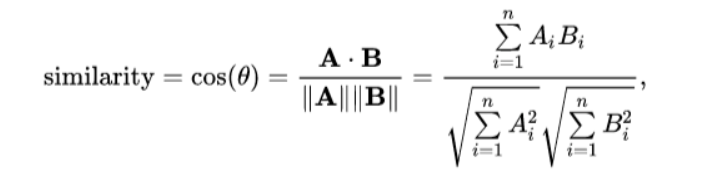

In [ ]:
def cosine_similarity(A, B):
 
    dot = np.dot(A,B)
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
    cos = dot / (norma*normb)
    return cos

Let's see the similarity between the words "**learning**" and "**intelligence**", and their indexes are 1 and 4 respectively. And the theory is if the similarity score is closer to 1, then the words are similar, cause as we know cos 0 degree is 1, so it works on that principle.

In [ ]:
cosine_similarity(embedding_matrix[1],embedding_matrix[4])

So here the similarity score between **learning** and **intelligence** is 0.40877, so the angle is somewhere in between 60 - 75 degree, so they are not quite similar. Now let's try to check the similarity of some other words.

In [ ]:
cosine_similarity(embeddings_dict["loss"],embeddings_dict["function"])

I am feeling like pre-trained Glove embeddings from all the wikipedia data is not so good for my data, we need to look at some other alternative.

# Word-Embedding using Fasttext

Here, I am not using pre-trained FastText embeddings, here I am using gensim library which provides us the support to train the embeddings from our own data, but very soon I will try the pre-trained version of FastText. 

In [ ]:
multiprocessing.cpu_count()

So we have 4 multi-core CPUs available, which we will use as workers.

In [ ]:
tokens_3 = [word for word in trigram_final[tokens]] 

In [ ]:
fastext_mdl = FastText(tokens_3,
                      window = 5,
                      size = 100,
                      alpha = 0.01,
                      min_alpha = 0.0005,
                      workers = multiprocessing.cpu_count(),
                      seed = 42)

So what are the parameters that I used in the FastText word-embedding model, they are:-
1. min_count -> It filters out all the word, which has frequency below the limit that we have chosen.
2. window -> It is, while the model trains for creating embedding for a particular word, it uses 5 words from the left, to the word it is creating embedding for, and 5 words to the right, as context.
3. size -> It is the dimension of the embedding.
4. alpha -> It is initial learning rate.
5. min_alpha -> The learning rate in these pre-trained algorithms are kept flexible, so later in the stage, when the model needs to converge and it is very close to the convergence point, then the model lowers the learning rate to minimum value, and converges.
6. workers -> It is used basically so as to speed up the process, as you know this kinda pre-trained models use neural network architecture, so it is a bit time-taking, so using multiple CPUs may reduce the training time.
7. seed -> Seed is used so that the next time when you run the model, the output doesn't change, try it yorself, don't use seed in your model, the next time when you run the model, the output will be different.

Now let's see the vocabulary size of our data.

In [ ]:
len(fastext_mdl.wv.vocab)

Now let's see the vector representation of the word "artificial". It's dimension will be 200. 

In [ ]:
print(fastext_mdl.wv['artificial_intelligence'])

Now let's try to see the similarity score of "machine learning" and "artificial intelligence". It will be in the range of 0 - 1. The more closer it will be towards 1, the more similar they are.

In [ ]:
print(fastext_mdl.wv.similarity(w1='artificial_intelligence', w2='machine_learning'))

# TSNE plot for the word-embeddings

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity = 30, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        #plt.annotate(labels[i],
                     #xy=(x[i], y[i]),
                     #xytext=(5, 2),
                     #textcoords='offset points',
                     #ha='right',
                     #va='bottom')
    plt.show()

In [ ]:
sns.set_style('whitegrid')
#plt.style.use("ggplot")
tsne_plot(fastext_mdl)

**Now the thing that is remaining is I need to create a documentary similarity using both Fasttext and Glove, and see how are they performing differently. Also further, I need to clean the data a little further.**